## Loading Dataset

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from  scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
from statsmodels.formula.api import ols
from pitchfork_functions import query_to_df, sample_size_calc, bootstrap_mean_stats, two_sample_ttest_stats
%matplotlib inline
conn = psycopg2.connect("dbname=musicdatabase")
cur = conn.cursor()

#### Loading SQLite into PostGreSQL:
Our original source file was a sqlite file which we wanted to load into PostGreSQL to be able to work safely locally and not rely on the original file.  We did so through the command line with the help of pgloader.  The steps we took were:
* Installing pgloader:  
    ```brew install pgloader```
* Creating our local database:  
    ```CREATEDB msuicdatabase```
* Executing pgloader:  
   ```pgloader music.sqlite postgresql:///musicdatabase```

## Creating DataFrames

In [2]:
# Genre table
genres_df = query_to_df("SELECT * FROM genres")

# Artists table
artists_df = query_to_df("SELECT * FROM artists")

# Content table
content_df = query_to_df("SELECT * FROM content")

# Labels table
labels_df = query_to_df("SELECT * FROM labels")

# Reviews table
reviews_df = query_to_df("SELECT * FROM reviews")

#Years table
years_df = query_to_df("SELECT * FROM years")

## Exploring the Data

In [3]:
print('genre df length: ', len(genres_df))
print('artists df length: ', len(artists_df))
print('content df length: ', len(content_df))
print('labels df length: ', len(labels_df))
print('reviews df length: ', len(reviews_df))
print('years df length: ', len(years_df))

genre df length:  22680
artists df length:  18831
content df length:  18393
labels df length:  20190
reviews df length:  18393
years df length:  19108


In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [5]:
reviews_df.isna().sum()
#no NANs in column 1.. however 2367 in column 2

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       3906
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
dtype: int64

## Seeing Which Tables Have Multiple Rows Per Song

In [6]:
labels_df.loc[labels_df['reviewid'] == 2626]
#example, song 6523 has 4 artists

,reviewid,label
14612,2626,cleopatra
14613,2626,alternative tentacles
14614,2626,manifesto
14615,2626,cherry red
14616,2626,irs


In researching our data, we found that many tables had multiple genres and labels per album.

In [7]:
reviews_df.loc[reviews_df['reviewid']==2626]

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
13198,2626,fresh fruit for rotting vegetables,dead kennedys,http://pitchfork.com/reviews/albums/2626-fresh...,7.0,0,cory d. byrom,None,2005-11-09,2,9,11,2005


* Review Table -- has 4 songs that have 2 reviewid's... i believe this is an error as all rows are identical
* Content Table -- also has 4 songs with 2 reviewid's... will remove the duplicated rows
* Genres Tabel -- Many songs have 2+ genres
* Labels Tabel -- Many songs have 2+ labels
* Artists Tabel -- Many songs have 2+ artists
* Year Tabel -- Many songs have 2+ release years... this may be an error... considering keeping only oldest year

In [8]:
labels_df['reviewid'].value_counts().head(10)

2626     5
21550    5
21387    4
17112    4
9505     4
17920    4
16092    4
16384    4
22065    4
22567    3
Name: reviewid, dtype: int64

## Combining Genre and Review Tables

Since we have albums that are listed under multiple genres, we needed to one hot encode our genres and then connect that data to our album table.

In [9]:
genres_one_hot = pd.get_dummies(genres_df['genre'])
genres_hot_df = pd.concat([genres_df, genres_one_hot], axis = 1)
genres_hot_df.drop('genre', axis=1, inplace=True)
genres_hot_df.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock
0,22703,1,0,0,0,0,0,0,0,0
1,22721,0,0,0,0,0,1,0,0,0
2,22659,0,0,0,0,0,0,0,0,1
3,22661,0,0,0,0,0,0,0,0,1
4,22725,1,0,0,0,0,0,0,0,0


Second, we filtered our genres table for only 

In [10]:
pop_elec_genres = genres_hot_df.loc[((genres_hot_df['pop/r&b'] == 1) | (genres_hot_df['electronic'] == 1)),
                                   ['reviewid', 'electronic', 'pop/r&b']]
pop_elec_genres.head()

,reviewid,electronic,pop/r&b
0,22703,1,0
4,22725,1,0
7,22694,1,0
12,22700,1,0
18,22719,0,1


Third, add value_count column in order to remove any albums that fall under both electronic & pop.

In [11]:
genre_counts = pop_elec_genres['reviewid'].value_counts()
genre_dict = genre_counts.to_dict()
pop_elec_genres['value_count'] = pop_elec_genres['reviewid'].apply(lambda x: genre_dict[x])
pop_elec_genres.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Remove albums with both electronic and pop (where value_counts = 2)

In [12]:
albums_to_drop = pop_elec_genres[pop_elec_genres['value_count'] >= 2]
pop_elec_genre_df = pop_elec_genres.drop(albums_to_drop.index, axis=0)

In [13]:
pop_elec_genre_df.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Merge the new Genre Table with the existing Review Table

In [14]:
rg_df = reviews_df.merge(pop_elec_genre_df, left_on='reviewid', right_on='reviewid')
rg_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,electronic,pop/r&b,value_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1,0,1
1,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,1,0,1
2,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,1,0,1
3,22700,nadir,steven warwick,http://pitchfork.com/reviews/albums/22700-nadir/,7.6,0,thea ballard,contributor,2017-01-03,1,3,1,2017,1,0,1
4,22719,merry christmas lil mama,"chance the rapper, jeremih",http://pitchfork.com/reviews/albums/22719-merr...,8.1,0,sheldon pearce,associate staff writer,2016-12-30,4,30,12,2016,0,1,1


## Hypothesis Test #1 
* Null: There is no statistically significant difference between the reviews for Pop/R&B albums and Electronic music albums.
* Alternative: The reviews for Pop/R&B albums and Electronic albums have a statistically significant difference between how they are reviewed, either positively or negatively. 

In [15]:
pop_df = rg_df[rg_df['pop/r&b'] == 1].copy()
elec_df = rg_df[rg_df['electronic'] == 1].copy()

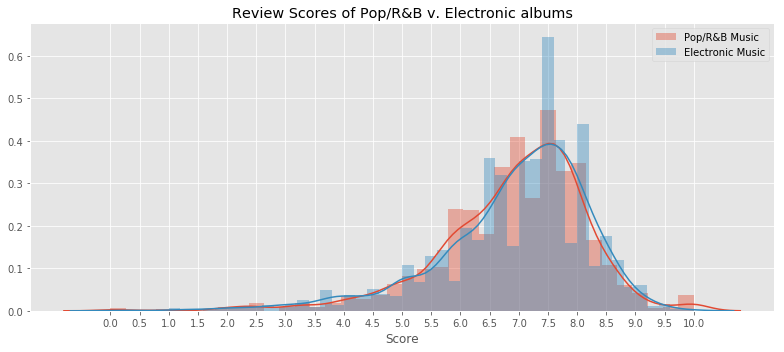

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(11,5))
sns.distplot(pop_df['score'], label="Pop/R&B Music")
sns.distplot(elec_df['score'], label="Electronic Music")
plt.title("Review Scores of Pop/R&B v. Electronic albums")
plt.xlabel('Score')
plt.xticks(np.arange(0,10.5, .5))
plt.tight_layout()
plt.legend()
plt.show();

In [17]:
# Created a helper function for Two Sample T-Test for our categorical comparissions.
two_sample_ttest_stats(pop_df['score'], elec_df['score'])

Sample 1 Review Mean:  6.918853820598006
Sampe 2 Review Mean:  6.934585847504114
Difference:  -0.01573202690610831
T-Statistic: -0.36421091026425517
P-Value: 0.7157164040794012


#### Bootstrap Check
We further performed bootstrap sampling on our data, to see if the values we arrived at are in line with what we might find from other samples of this data. 

##### Finding Appropriate Sample Size

In [18]:
# Using sample size calculation converted into a function
sample_size_calc(pop_df['score'],elec_df['score'], moe=.5)

87.64595381733723

Appropriate sample size must be greater than 87.6

In [19]:
samp_size = 90

In [20]:
std, low_p, high_p = bootstrap_mean_stats(pop_df['score'], sample_size=90, n_tests=100)
print(f"Pop Sample Means Stdv: {std}\nPop 2.5 Percentile: {low_p}\nPop 97.5 Percentile: {high_p}")

Pop Sample Means Stdv: 0.1383
Pop 2.5 Percentile: 6.6132
Pop 97.5 Percentile: 7.1695


In [21]:
std, low_p, high_p = bootstrap_mean_stats(elec_df['score'], sample_size=90, n_tests=100)
print(f"Elec Sample Means Stdv: {std}\nElec 2.5 Percentile: {low_p}\nElec 97.5 Percentile: {high_p}")

Elec Sample Means Stdv: 0.1299
Elec 2.5 Percentile: 6.6983
Elec 97.5 Percentile: 7.1734


#### Summary: Hypothesis #1

Through our exploration, we found there to be very little variability between the rating of the two genres. We found a p-value of .716, which far exceeds our threshold of .05, telling us that we must accept our null hypothesis that there is not a statistically significant difference between the rating of Pop/R&B and Electronic albums.

In our further bootstrap test, sampling our data, we did not find significant variability in the performance of our two groups.

## Hypothesis Test #2
* Null: In sampling the 500 worst and 500 best reviewed albums, there is no statistically significant difference in the genres each represents with regards to score. 
* Alternative: The 500 worst reviewed and 500 best reviewed albums have a statistically significant difference in the genres they have. 

### 500 Best Rated Albums

In [22]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score DESC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
best_100 = pd.DataFrame(cur.fetchall(),columns=names)
best_wgenres = genres_hot_df.merge(best_100, on='reviewid')
best_wgenres.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22703,1,0,0,0,0,0,0,0,0,9.3,nate patrin,contributor
1,22661,0,0,0,0,0,0,0,0,1,9.0,jenn pelly,associate reviews editor
2,22707,0,0,0,0,1,0,0,0,0,9.0,seth colter-walls,contributor
3,22643,0,0,0,0,0,0,0,0,1,9.3,jesse jarnow,contributor
4,22555,1,0,0,0,0,0,0,0,0,9.5,andy beta,contributor


### 500 Worst Rated Albums

In [23]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score ASC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
worst_100 = pd.DataFrame(cur.fetchall(),columns=names)
worst_wgenres = genres_hot_df.merge(worst_100, on='reviewid')
worst_wgenres.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22720,0,0,0,0,0,0,0,1,0,3.5,marcus j. moore,contributor
1,22589,1,0,0,0,0,0,0,0,0,3.5,kevin lozano,tracks coordinator
2,22319,0,0,0,0,0,0,0,0,1,2.0,ian cohen,contributor
3,22319,0,0,0,0,0,0,0,1,0,2.0,ian cohen,contributor
4,22143,1,0,0,0,0,0,0,0,0,2.5,stacey anderson,associate features editor


In [24]:
# Correcting column names for use in ANOVA test
best_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)
worst_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)

In [25]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df          F    PR(>F)
C(rock)           0.407402    1.0   3.708124  0.054633
C(electronic)     0.018879    1.0   0.171834  0.678639
C(rap)            0.544781    1.0   4.958531  0.026342
C(metal)          0.062107    1.0   0.565292  0.452438
C(experimental)   0.019272    1.0   0.175411  0.675500
C(jazz)           0.157476    1.0   1.433328  0.231707
C(pop_rb)         1.148879    1.0  10.456954  0.001291
C(folk_country)   0.019713    1.0   0.179424  0.672025
Residual         64.272491  585.0        NaN       NaN


Looking at the P-values of our ANOVA test, we found that those albums appearing in the top 500 reviewed albums that received higher scores appeared to be highly correlated to being either Pop/R&B or Rap (with Rock being very close as well).

### Creating ANOVA tables for Worst rated songs:

In [26]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df         F    PR(>F)
C(rock)            0.172404    1.0  0.225969  0.634690
C(electronic)      1.091531    1.0  1.430664  0.232096
C(rap)             0.101879    1.0  0.133532  0.714918
C(metal)           0.023072    1.0  0.030241  0.862000
C(experimental)    0.146514    1.0  0.192035  0.661375
C(jazz)            0.686205    1.0  0.899406  0.343297
C(pop_rb)          0.126617    1.0  0.165956  0.683867
C(folk_country)    0.556711    1.0  0.729678  0.393305
Residual         491.342202  644.0       NaN       NaN


For our ANOVA test on the worst rated albums, we did not find any genre with a statisttically significant relation to the score they received.  This being said, it would appear that bad albums are considered such, and there is potentially no bias for this based genre.

Based on these results, we decided to drill more into the reviewers and how they scored.  Here is a brief digression into the scoring of top 500 reviews by the author type:

#### Creating encoding for review by author type:

In [27]:
# Create reviewer types
reviewer = list(best_wgenres['author_type'].value_counts().index)

rev_names = {}
for r in reviewer:
    rev_names[r] = r.replace(" ","_")
rev_names

{'contributor': 'contributor',
 'executive editor': 'executive_editor',
 'senior editor': 'senior_editor',
 'editor-in-chief': 'editor-in-chief',
 'contributing editor': 'contributing_editor',
 'associate reviews editor': 'associate_reviews_editor',
 'senior staff writer': 'senior_staff_writer',
 'deputy news editor': 'deputy_news_editor'}

In [28]:
# Performing manual one hot encoding on reviews by author type:
for old, new in rev_names.items():
    best_wgenres[new] = best_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)
    worst_wgenres[new] = worst_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)

In [29]:
best_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)
worst_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)

####  ANOVA Table for author type by review score: Best scores

In [30]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(contributing_editor) + C(associate_reviews_editor) 
            + C(senior_staff_writer) + C(deputy_news_editor)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq     df         F    PR(>F)
C(contributor)                0.099847    1.0  0.895279  0.344441
C(executive_editor)           0.632875    1.0  5.674655  0.017530
C(senior_editor)              0.080004    1.0  0.717355  0.397359
C(ec)                         0.200698    1.0  1.799553  0.180287
C(contributing_editor)        0.066484    1.0  0.596123  0.440373
C(associate_reviews_editor)   0.277094    1.0  2.484554  0.115510
C(senior_staff_writer)        0.099482    1.0  0.892007  0.345324
C(deputy_news_editor)         0.047042    1.0  0.421799  0.516296
Residual                     65.243010  585.0       NaN       NaN


#### ANOVA Table for author type by review score: Worst scores

In [31]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(senior_staff_writer)"""
worst = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(worst, typ=2)
print(table)

                            sum_sq     df         F    PR(>F)
C(contributor)            0.207015    1.0  0.273110  0.601432
C(executive_editor)       0.398292    1.0  0.525460  0.468784
C(senior_editor)          0.463840    1.0  0.611935  0.434346
C(ec)                     2.182150    1.0  2.878869  0.090230
C(senior_staff_writer)    0.470435    1.0  0.620636  0.431099
Residual                490.418612  647.0       NaN       NaN


#### Summary: Hypothesis #2

Based on the results of our ANOVA test, we were able to reject our null hypothesis and say that there is a statistically significant difference between how genres are scored between the top 500 rated albums and the worst 500 rated albums.  Pop/R&B and Rap albums appear to be correlated to higher scores within the top 500 rated albums. To further look into this, we can see that part of the reason may be that there are so few albums of these genres are actually represented in the top 500. 

In [32]:
print(f""" Percent of Top 500 Rap or Pop/R&B: {round((((len(best_wgenres[best_wgenres['rap'] == 1]) +
 len(best_wgenres[best_wgenres['pop_rb'] == 1])) / best_wgenres.shape[0]) * 100), 2)}% """)

 Percent of Top 500 Rap or Pop/R&B: 10.77% 


In reviewing scores by author type, there does seem to be some correlation between the Executive Editor and the score those in the top 500 receive.  This could be understood as that position getting the best assignments that come in based on their musical knowledge, but with this showing significance, it seemed worth looking into how different reviewers score albums.  

## Hypothesis Test #3
* Null Hypothesis: There is no statistical difference between the top reviewers (5 reviewers who scored the most albums) scores between genres.
* Alternative: There is a statistical difference between the top reviewers (5 reviewers who scored the most albums) scores between genres.

In [33]:
# Top 5 reviewers
query = """
SELECT 
    author
,   COUNT(*) review_count
FROM 
    reviews
GROUP BY
    author
ORDER BY
    review_count DESC
LIMIT 5
"""

top_5 = query_to_df(query)
top_5

,author,review_count
0,joe tangari,816
1,stephen m. deusner,725
2,ian cohen,699
3,brian howe,500
4,mark richardson,476


In [34]:
# Gathering all reviewers with over 100 reviews.
query = """
SELECT 
    *
FROM 
    reviews
INNER JOIN
    (SELECT 
        author,
        CASE WHEN COUNT(*) > 100 THEN 1 ELSE 0 END as greater_than_100
     FROM 
        reviews
     GROUP BY
        author) as auth_reviews
USING (author)
"""

author_reviews = query_to_df(query)
author_reviews.head()

,author,reviewid,title,artist,url,score,best_new_music,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,greater_than_100
0,nate patrin,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,contributor,2017-01-08,6,8,1,2017,1
1,zoe camp,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,contributor,2017-01-07,5,7,1,2017,0
2,david glickman,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,contributor,2017-01-07,5,7,1,2017,0
3,jenn pelly,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,associate reviews editor,2017-01-06,4,6,1,2017,0
4,kevin lozano,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,tracks coordinator,2017-01-06,4,6,1,2017,0


In [37]:
#Author & Genre DB all with binary encoded values
author_gen_df = author_reviews.merge(genres_hot_df, left_on='reviewid', right_on='reviewid')

In [38]:
#Each genre for authors with >100 reviews:
elec_df = author_gen_df[(author_gen_df['electronic'] == 1) & (author_gen_df['greater_than_100'] == 1)]
pop_df = author_gen_df[(author_gen_df['pop/r&b'] == 1) & (author_gen_df['greater_than_100'] == 1)]

In [39]:
# Exploring the Top 5 reviewers
reviewers = ['joe tangari', 'ian cohen', 'mark richardson', 'stephen m. deusner']

In [40]:
print("Top Reviewers Pop/R&B Scores\n")
for name in reviewers:
    print(f"""{name.title()}: 
    Mean Score: {round(pop_df.loc[pop_df['author'] == name, 'score'].mean(),3)}
    Std Dev: {round(pop_df.loc[pop_df['author'] == name, 'score'].std(),3)}""")

Top Reviewers Pop/R&B Scores

Joe Tangari: 
    Mean Score: 7.434
    Std Dev: 0.799
Ian Cohen: 
    Mean Score: 6.538
    Std Dev: 1.433
Mark Richardson: 
    Mean Score: 7.029
    Std Dev: 1.593
Stephen M. Deusner: 
    Mean Score: 6.866
    Std Dev: 1.295


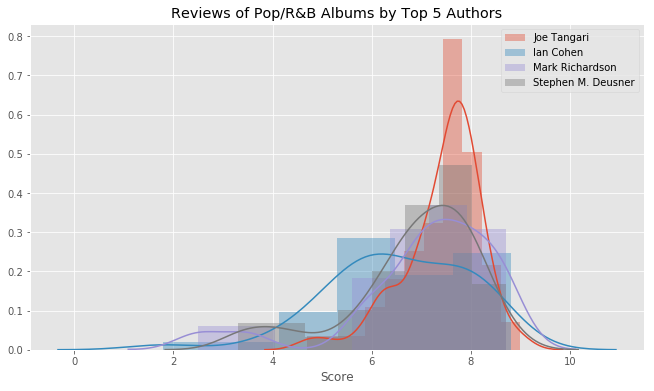

In [41]:
#Graph of Top 5 reviewers score of Pop/R&B Albums
plt.figure(figsize=(11,6))
for name in reviewers:
    sns.distplot(pop_df.loc[pop_df['author'] == name, 'score'],
                 label=name.title(), hist=True, kde=True)
plt.title("Reviews of Pop/R&B Albums by Top 5 Authors")
plt.xlabel("Score")
plt.legend()
plt.show();

In [42]:
print("Top Reviewers Electronic Scores\n")
for name in reviewers:
    print(f"""{name.title()}: 
    Mean Score: {round(elec_df.loc[elec_df['author'] == name, 'score'].mean(), 3)}
    Std Dev: {round(elec_df.loc[elec_df['author'] == name, 'score'].std(),3)}""")

Top Reviewers Electronic Scores

Joe Tangari: 
    Mean Score: 7.273
    Std Dev: 0.882
Ian Cohen: 
    Mean Score: 5.934
    Std Dev: 1.799
Mark Richardson: 
    Mean Score: 7.377
    Std Dev: 1.228
Stephen M. Deusner: 
    Mean Score: 6.874
    Std Dev: 1.208


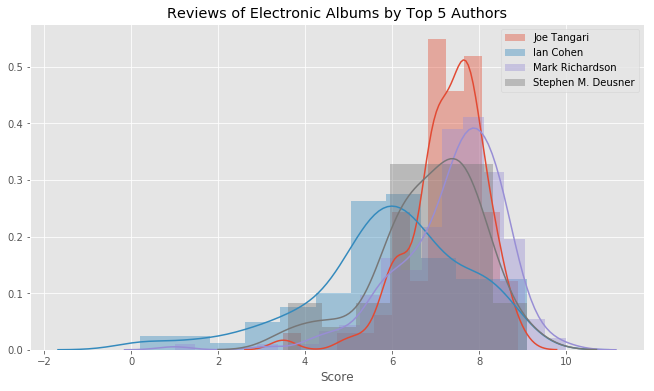

In [43]:
#Graph of Top 5 reviewers score of Pop/R&B Albums
plt.figure(figsize=(11,6))
for name in reviewers:
    sns.distplot(elec_df.loc[elec_df['author'] == name, 'score'], label=name.title(), hist=True, kde=True)
plt.title("Reviews of Electronic Albums by Top 5 Authors")
plt.xlabel("Score")
plt.legend()
plt.show();

In [44]:
# Looking at how much each of Top 5 reviewers differ from each other on Pop/R&B scores with Two Sample T-Test
for com in combinations(reviewers,2):
    print(com)
    two_sample_ttest_stats(pop_df.loc[pop_df['author'] == com[0], 'score'], 
                           pop_df.loc[pop_df['author'] == com[1], 'score'])
    print('\n')

('joe tangari', 'ian cohen')
Sample 1 Review Mean:  7.433802816901408
Sampe 2 Review Mean:  6.537777777777777
Difference:  0.8960250391236313
T-Statistic: 4.320562728882836
P-Value: 3.341563304143575e-05


('joe tangari', 'mark richardson')
Sample 1 Review Mean:  7.433802816901408
Sampe 2 Review Mean:  7.0285714285714285
Difference:  0.4052313883299794
T-Statistic: 1.5841638110459617
P-Value: 0.11666419657870923


('joe tangari', 'stephen m. deusner')
Sample 1 Review Mean:  7.433802816901408
Sampe 2 Review Mean:  6.86590909090909
Difference:  0.5678937259923176
T-Statistic: 2.9111091591865117
P-Value: 0.0043395818277747


('ian cohen', 'mark richardson')
Sample 1 Review Mean:  6.537777777777777
Sampe 2 Review Mean:  7.0285714285714285
Difference:  -0.4907936507936519
T-Statistic: -1.250974380466433
P-Value: 0.21549769531905105


('ian cohen', 'stephen m. deusner')
Sample 1 Review Mean:  6.537777777777777
Sampe 2 Review Mean:  6.86590909090909
Difference:  -0.3281313131313137
T-Statisti

In [45]:
# Top 5 reviewers v. all others on Pop/R&B Albums
for name in reviewers:
    print(f"{name.title()} v. all others - Pop/R&B")
    two_sample_ttest_stats(pop_df.loc[pop_df['author'] == name, 'score'], 
                           pop_df.loc[pop_df['author'] != name, 'score'])
    print('\n')

Joe Tangari v. all others - Pop/R&B
Sample 1 Review Mean:  7.433802816901408
Sampe 2 Review Mean:  6.829999999999999
Difference:  0.6038028169014087
T-Statistic: 3.780454572238638
P-Value: 0.0001674971905368177


Ian Cohen v. all others - Pop/R&B
Sample 1 Review Mean:  6.537777777777777
Sampe 2 Review Mean:  6.899503722084368
Difference:  -0.361725944306591
T-Statistic: -1.8211575146393946
P-Value: 0.06893474620182803


Mark Richardson v. all others - Pop/R&B
Sample 1 Review Mean:  7.0285714285714285
Sampe 2 Review Mean:  6.876626506024097
Difference:  0.15194492254733127
T-Statistic: 0.5293634936838577
P-Value: 0.5966917001244822


Stephen M. Deusner v. all others - Pop/R&B
Sample 1 Review Mean:  6.86590909090909
Sampe 2 Review Mean:  6.881164807930608
Difference:  -0.015255717021517512
T-Statistic: -0.07584808890471785
P-Value: 0.9395578256480192




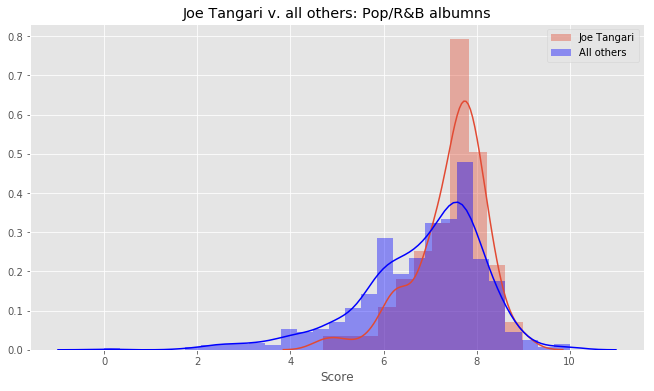

In [46]:
plt.figure(figsize=(11,6))

sns.distplot(pop_df.loc[pop_df['author'] == 'joe tangari', 'score'],
             label='Joe Tangari', hist=True, kde=True)
sns.distplot(pop_df.loc[pop_df['author'] != 'joe tangari', 'score'],
             label='All others', hist=True, kde=True, color='blue')
plt.title("Joe Tangari v. all others: Pop/R&B albumns")
plt.xlabel("Score")
plt.legend()
plt.show();

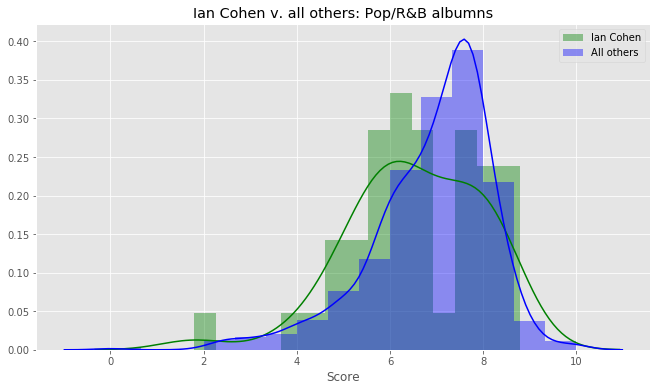

In [47]:
plt.figure(figsize=(11,6))

sns.distplot(pop_df.loc[pop_df['author'] == 'ian cohen', 'score'], bins=15,
             label='Ian Cohen', hist=True, kde=True, color='green')
sns.distplot(pop_df.loc[pop_df['author'] != 'ian cohen', 'score'], bins=15,
             label='All others', hist=True, kde=True, color='blue')
plt.title("Ian Cohen v. all others: Pop/R&B albumns")
plt.xlabel("Score")
plt.legend()
plt.show();

In [48]:
# Looking at how much each of Top 5 reviewers differ from each other on Electronic scores with Two Sample T-Test
for com in combinations(reviewers,2):
    print(com)
    two_sample_ttest_stats(elec_df.loc[elec_df['author'] == com[0], 'score'], 
                           elec_df.loc[elec_df['author'] == com[1], 'score'])
    print('\n')

('joe tangari', 'ian cohen')
Sample 1 Review Mean:  7.273417721518986
Sampe 2 Review Mean:  5.934343434343433
Difference:  1.3390742871755528
T-Statistic: 6.056563092058852
P-Value: 8.203704143786283e-09


('joe tangari', 'mark richardson')
Sample 1 Review Mean:  7.273417721518986
Sampe 2 Review Mean:  7.377435897435897
Difference:  -0.1040181759169112
T-Statistic: -0.6842955243514649
P-Value: 0.4943711829530054


('joe tangari', 'stephen m. deusner')
Sample 1 Review Mean:  7.273417721518986
Sampe 2 Review Mean:  6.8741935483870975
Difference:  0.3992241731318886
T-Statistic: 1.9152418324630343
P-Value: 0.05810660455179533


('ian cohen', 'mark richardson')
Sample 1 Review Mean:  5.934343434343433
Sampe 2 Review Mean:  7.377435897435897
Difference:  -1.443092463092464
T-Statistic: -8.090463051689461
P-Value: 1.6092604672962214e-14


('ian cohen', 'stephen m. deusner')
Sample 1 Review Mean:  5.934343434343433
Sampe 2 Review Mean:  6.8741935483870975
Difference:  -0.9398501140436641
T-St

In [49]:
# Top 5 reviewers v. all others on Electronic albums
for name in reviewers:
    print(f"{name.title()} v. all others - Electronic")
    two_sample_ttest_stats(elec_df.loc[elec_df['author'] == name, 'score'], 
                           elec_df.loc[elec_df['author'] != name, 'score'])
    print('\n')

Joe Tangari v. all others - Electronic
Sample 1 Review Mean:  7.273417721518986
Sampe 2 Review Mean:  6.923762010347376
Difference:  0.3496557111716099
T-Statistic: 2.322957970558429
P-Value: 0.020253158670236762


Ian Cohen v. all others - Electronic
Sample 1 Review Mean:  5.934343434343433
Sampe 2 Review Mean:  6.970513775130305
Difference:  -1.0361703407868719
T-Statistic: -7.752540033739438
P-Value: 1.25350200783666e-14


Mark Richardson v. all others - Electronic
Sample 1 Review Mean:  7.377435897435897
Sampe 2 Review Mean:  6.900270270270269
Difference:  0.47716562716562816
T-Statistic: 4.888727510765283
P-Value: 1.072525667502017e-06


Stephen M. Deusner v. all others - Electronic
Sample 1 Review Mean:  6.8741935483870975
Sampe 2 Review Mean:  6.9343500363108195
Difference:  -0.06015648792372197
T-Statistic: -0.2523207151759934
P-Value: 0.8008118104968299




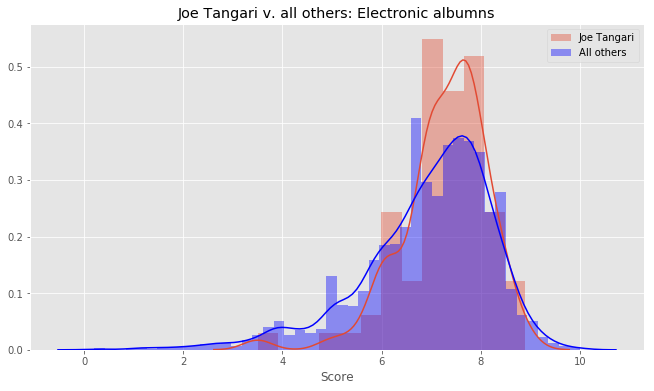

In [50]:
plt.figure(figsize=(11,6))

sns.distplot(elec_df.loc[elec_df['author'] == 'joe tangari', 'score'],
             label='Joe Tangari', hist=True, kde=True)
sns.distplot(elec_df.loc[elec_df['author'] != 'joe tangari', 'score'],
             label='All others', hist=True, kde=True, color='blue')
plt.title("Joe Tangari v. all others: Electronic albumns")
plt.xlabel("Score")
plt.legend()
plt.show();

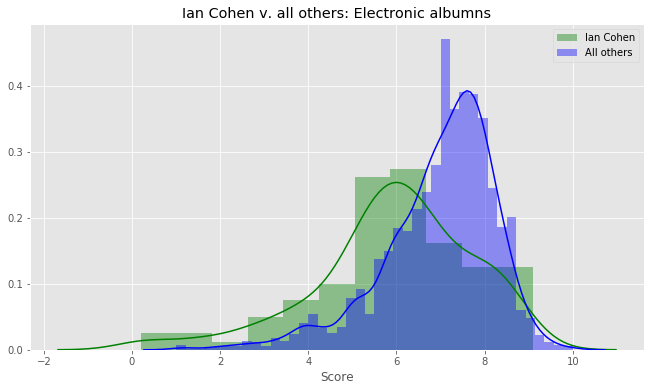

In [51]:
plt.figure(figsize=(11,6))

sns.distplot(elec_df.loc[elec_df['author'] == 'ian cohen', 'score'],
             label='Ian Cohen', hist=True, kde=True, color='green')
sns.distplot(elec_df.loc[elec_df['author'] != 'ian cohen', 'score'],
             label='All others', hist=True, kde=True,color='blue')
plt.title("Ian Cohen v. all others: Electronic albumns")
plt.xlabel("Score")
plt.legend()
plt.show();

#### Summary: Hypothesis #3

Based on the results, we reject the null hypothesis and accept that there are certain reviewers who write more favorable reviews for different genres. In particular, Ian tends to review albums with greater variability and critic than others. Although Mark tends to score slightly higher than Joe, it is not statistically significant.   

## Hypothesis Test #4
* Null: There is no statistically significant difference between self-released album ratings and all others. 
* Alternative: Self-released albums have a statistically significant decrease in ratings compared to other labels.

In [52]:
# Finding albums with multiple labels
multi_label = dict(labels_df['reviewid'].value_counts())
labels_df['label count'] = labels_df['reviewid'].apply(lambda x: multi_label[x])
labels_df.head()

,reviewid,label,label count
0,22703,virgin,1
1,22721,hathenter,1
2,22659,static shock,2
3,22659,fashionable idiots,2
4,22661,kill rock stars,2


In [53]:
# removing duplicate labels per album
to_drop = labels_df[labels_df['label count'] > 1]
label_solo_df = labels_df.drop(to_drop.index, axis=0)
revlab_df = reviews_df.merge(label_solo_df, left_on='reviewid', right_on='reviewid')

In [54]:
self_df = revlab_df[revlab_df['label'] == 'self-released'].copy()
label_df = revlab_df[revlab_df['label'] != 'self-released'].copy()

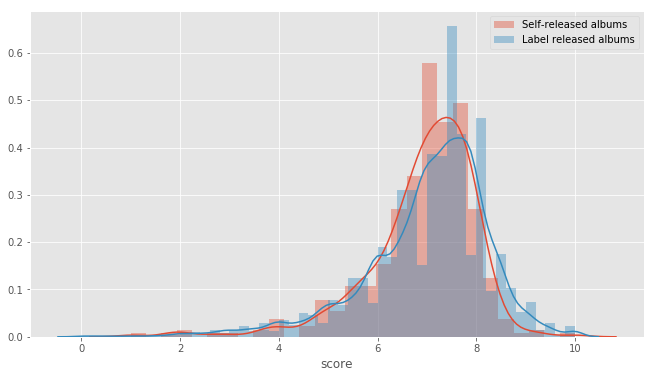

In [55]:
plt.figure(figsize=(11,6))
sns.distplot(self_df['score'], label='Self-released albums');
sns.distplot(label_df['score'], label='Label released albums');
plt.legend()
plt.show();

In [56]:
two_sample_ttest_stats(self_df['score'], label_df['score'])

Sample 1 Review Mean:  6.918181818181819
Sampe 2 Review Mean:  7.009612678210855
Difference:  -0.09143086002903633
T-Statistic: -1.4400160399176198
P-Value: 0.14988154041527244


In [57]:
sample_size_calc(self_df['score'], label_df['score'])

20.742462442038583

In [60]:
std, low_p, high_p = bootstrap_mean_stats(label_df['score'], sample_size=25, n_tests=100)
print(f"Label Sample Means Stdv: {std}\nPop 2.5 Percentile: {low_p}\nPop 97.5 Percentile: {high_p}")

Label Sample Means Stdv: 0.2627
Pop 2.5 Percentile: 6.579
Pop 97.5 Percentile: 7.5107


In [61]:
std, low_p, high_p = bootstrap_mean_stats(self_df['score'], sample_size=25, n_tests=100)
print(f"Label Sample Means Stdv: {std}\nPop 2.5 Percentile: {low_p}\nPop 97.5 Percentile: {high_p}")

Label Sample Means Stdv: 0.2131
Pop 2.5 Percentile: 6.552
Pop 97.5 Percentile: 7.3002


#### Summary: Hypothesis #4

Based on the results, we accept our null hypothesis, due to our two sample t-test resulting in a P-value of .149. The review scores for both self published and label publshed do no appear to have favorable scores. 

## Additional Work - Twitter Followers

In [72]:
# Mean difference between these categories and others
# If possible pull out Twitter stats for writers
top_authors = ['joe tangari', 'ian cohen', 'stephen m. deusner', 'brian howe', 'mark richardson']
author_tw = pd.read_csv('author_twitter.csv', index_col=0)
author_tw.sort_values(by=['followers'], ascending=False).head()

,followers,author,twitter
29,44768,laura snapes,@laurasnapes
15,25361,brandon stosuy,@brandonstosuy
24,20121,lindsay zoladz,@lindsayzoladz
25,19338,ian cohen,@en_cohen
33,18929,mark richardson,@markrichardson


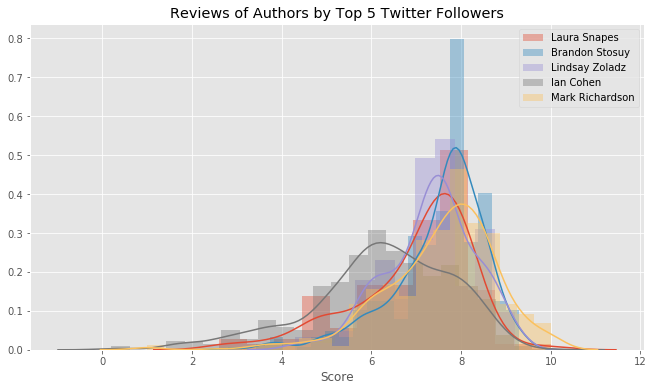

In [120]:
top_tweeters = ['laura snapes', 'brandon stosuy', 'lindsay zoladz', 'ian cohen', 'mark richardson']

plt.figure(figsize=(11,6))
for name in top_tweeters:
    sns.distplot(author_gen_df.loc[author_gen_df['author'] == name, 'score'],
                 label=name.title(), hist=True, kde=True)
plt.title("Reviews of Authors by Top 5 Twitter Followers")
plt.xlabel("Score")
plt.legend()
plt.show();

In [121]:
# Top social v. all others on Electronic albums
for name in top_tweeters:
    print(f"{name.title()} v. all others - Electronic")
    two_sample_ttest_stats(elec_df.loc[elec_df['author'] == name, 'score'], 
                           elec_df.loc[elec_df['author'] != name, 'score'])
    print('\n')

Laura Snapes v. all others - Electronic
Sample 1 Review Mean:  6.86
Sampe 2 Review Mean:  6.934079422382672
Difference:  -0.07407942238267129
T-Statistic: -0.2167651292085414
P-Value: 0.8284072768686802


Brandon Stosuy v. all others - Electronic
Sample 1 Review Mean:  7.322857142857143
Sampe 2 Review Mean:  6.928727272727273
Difference:  0.3941298701298699
T-Statistic: 1.7562360961997954
P-Value: 0.07915808468252286


Lindsay Zoladz v. all others - Electronic
Sample 1 Review Mean:  7.241666666666666
Sampe 2 Review Mean:  6.932347637937252
Difference:  0.30931902872941386
T-Statistic: 0.8100765186722234
P-Value: 0.41796545878818936


Ian Cohen v. all others - Electronic
Sample 1 Review Mean:  5.934343434343433
Sampe 2 Review Mean:  6.970513775130305
Difference:  -1.0361703407868719
T-Statistic: -7.752540033739438
P-Value: 1.25350200783666e-14


Mark Richardson v. all others - Electronic
Sample 1 Review Mean:  7.377435897435897
Sampe 2 Review Mean:  6.900270270270269
Difference:  0.4771

In [122]:
# Top 5 reviewers v. all others on Pop/R&B Albums
for name in top_tweeters:
    print(f"{name.title()} v. all others - Pop/R&B")
    two_sample_ttest_stats(pop_df.loc[pop_df['author'] == name, 'score'], 
                           pop_df.loc[pop_df['author'] != name, 'score'])
    print('\n')

Laura Snapes v. all others - Pop/R&B
Sample 1 Review Mean:  7.247368421052633
Sampe 2 Review Mean:  6.8719951923076925
Difference:  0.37537322874494006
T-Statistic: 1.2463676161059265
P-Value: 0.21297324589415156


Brandon Stosuy v. all others - Pop/R&B
Sample 1 Review Mean:  6.866666666666667
Sampe 2 Review Mean:  6.880424528301886
Difference:  -0.013757861635219193
T-Statistic: -0.018308679312946743
P-Value: 0.9853969052175285


Lindsay Zoladz v. all others - Pop/R&B
Sample 1 Review Mean:  6.857142857142857
Sampe 2 Review Mean:  6.880963855421687
Difference:  -0.023820998278829997
T-Statistic: -0.08297702378395043
P-Value: 0.9338893681480673


Ian Cohen v. all others - Pop/R&B
Sample 1 Review Mean:  6.537777777777777
Sampe 2 Review Mean:  6.899503722084368
Difference:  -0.361725944306591
T-Statistic: -1.8211575146393946
P-Value: 0.06893474620182803


Mark Richardson v. all others - Pop/R&B
Sample 1 Review Mean:  7.0285714285714285
Sampe 2 Review Mean:  6.876626506024097
Difference:  

/Users/nawjux/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/nawjux/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


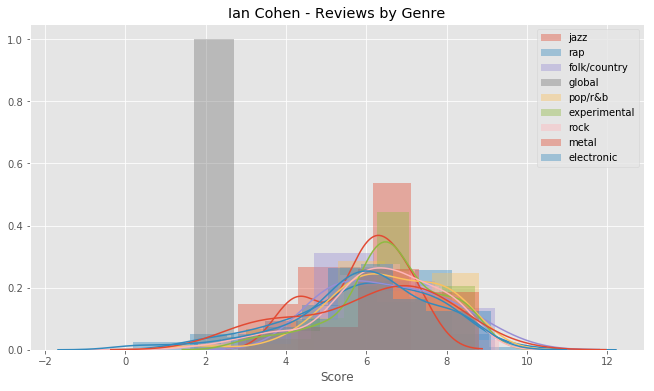

In [125]:
genres = list(set(genres_df['genre']))
genres.remove(None)

plt.figure(figsize=(11,6))
for genre in genres:
    sns.distplot(author_gen_df.loc[((author_gen_df['author'] == 'ian cohen') &
                                    (author_gen_df[genre] == 1)), 'score'],
                 label=genre, hist=True, kde=True)
plt.title("Ian Cohen - Reviews by Genre")
plt.xlabel("Score")
plt.legend()
plt.show();

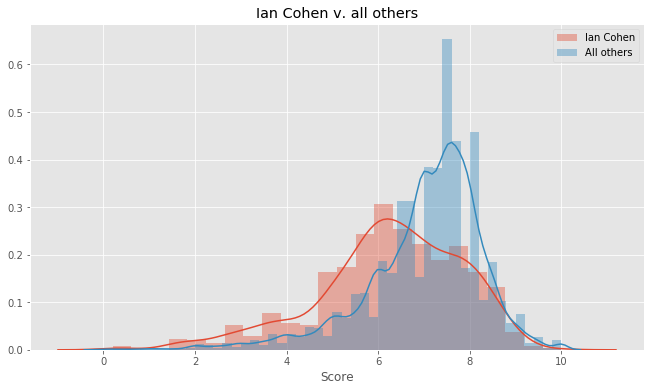

In [127]:
plt.figure(figsize=(11,6))
sns.distplot(author_gen_df.loc[author_gen_df['author'] == 'ian cohen', 'score'],
                 label='Ian Cohen', hist=True, kde=True)
sns.distplot(author_gen_df.loc[author_gen_df['author'] != 'ian cohen', 'score'],
                 label='All others', hist=True, kde=True)
plt.title("Ian Cohen v. all others")
plt.xlabel("Score")
plt.legend()
plt.show();